In [1]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from dfply import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from keras.models import Sequential
from keras import layers
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
data = 'Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(data)

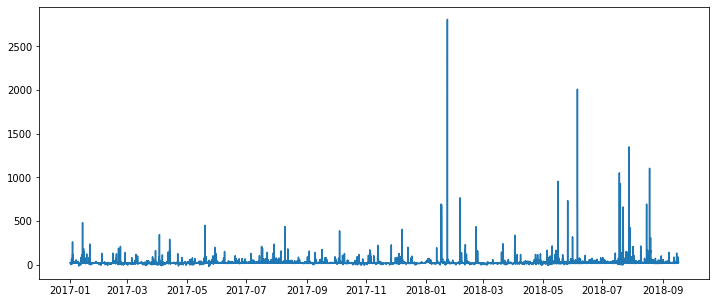

In [3]:
plt.figure(figsize=(12,5))
plt.plot(df['DATETIME'], df['HB_NORTH (RTLMP)'])
plt.show()

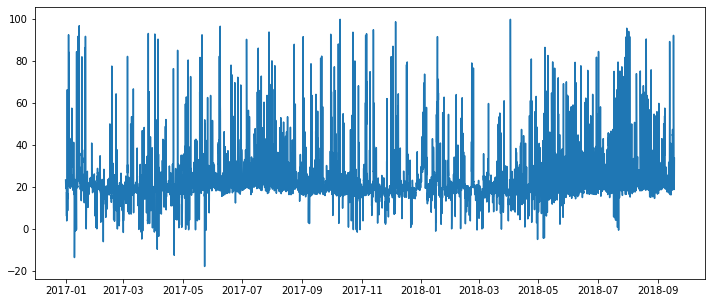

In [4]:
df_filtered = df[df['HB_NORTH (RTLMP)'] <= 100]
plt.figure(figsize=(12,5))
plt.plot(df_filtered['DATETIME'], df_filtered['HB_NORTH (RTLMP)'])
plt.show()

In [5]:
print('Proportion of price < 0: '+ str(round(df[df['HB_NORTH (RTLMP)'] < 0].shape[0] / df.shape[0], 4)))
print('Proportion of price < 100: '+ str(round(df[df['HB_NORTH (RTLMP)'] < 100].shape[0] / df.shape[0], 4)))

Proportion of price < 0: 0.005
Proportion of price < 100: 0.987


In [6]:
df = df.rename(columns={'HB_NORTH (RTLMP)': 'RTLMP', 'ERCOT (WIND_RTI)': 'WIND_RTI', 
                        'ERCOT (GENERATION_SOLAR_RT)': 'GENERATION_SOLAR_RT', 'ERCOT (RTLOAD)': 'RTLOAD'})
dfyear = (df >> group_by(X.YEAR) 
          >> summarize(PRICE_MEAN = X.RTLMP.mean(), WIND_MEAN = X.WIND_RTI.mean(), 
                       SOLAR_MEAN = X.GENERATION_SOLAR_RT.mean(), LOAD_MEAN = X.RTLOAD.mean()) 
          >> select(X.YEAR, X.PRICE_MEAN, X.WIND_MEAN, X.SOLAR_MEAN, X.LOAD_MEAN))
dfyear

,YEAR,PRICE_MEAN,WIND_MEAN,SOLAR_MEAN,LOAD_MEAN
0,2017,23.255672,7108.951557,240.999904,40822.411716
1,2018,29.298474,8128.335901,363.707955,44551.139738


In [7]:
dfmonth = (df >> group_by(X.MONTH) 
           >> summarize(PRICE_MEAN = X.RTLMP.mean(), WIND_MEAN = X.WIND_RTI.mean(), 
                       SOLAR_MEAN = X.GENERATION_SOLAR_RT.mean(), LOAD_MEAN = X.RTLOAD.mean()) 
           >> select(X.MONTH, X.PRICE_MEAN, X.WIND_MEAN, X.SOLAR_MEAN, X.LOAD_MEAN))

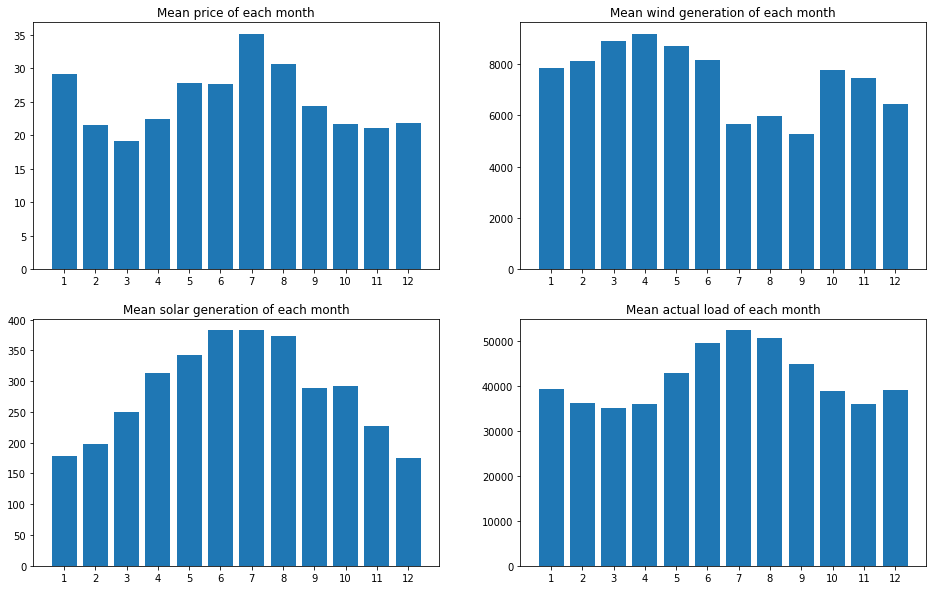

In [8]:
dfmonth['MONTH'] = dfmonth['MONTH'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)
fig, axs = plt.subplots(2, 2, figsize=(16,10))
axs[0,0].bar(dfmonth['MONTH'], dfmonth['PRICE_MEAN'])
axs[0,0].set_title('Mean price of each month')
axs[0,0].set_xticks(np.arange(1, 13))
axs[0,1].bar(dfmonth['MONTH'], dfmonth['WIND_MEAN'])
axs[0,1].set_title('Mean wind generation of each month')
axs[0,1].set_xticks(np.arange(1, 13))
axs[1,0].bar(dfmonth['MONTH'], dfmonth['SOLAR_MEAN'])
axs[1,0].set_title('Mean solar generation of each month')
axs[1,0].set_xticks(np.arange(1, 13))
axs[1,1].bar(dfmonth['MONTH'], dfmonth['LOAD_MEAN'])
axs[1,1].set_title('Mean actual load of each month')
axs[1,1].set_xticks(np.arange(1, 13))

In [9]:
dfhe = (df >> group_by(X.HOURENDING) 
        >> summarize(PRICE_MEAN = X.RTLMP.mean(), WIND_MEAN = X.WIND_RTI.mean(), 
                    SOLAR_MEAN = X.GENERATION_SOLAR_RT.mean(), LOAD_MEAN = X.RTLOAD.mean()) 
        >> select(X.HOURENDING, X.PRICE_MEAN, X.WIND_MEAN, X.SOLAR_MEAN, X.LOAD_MEAN))

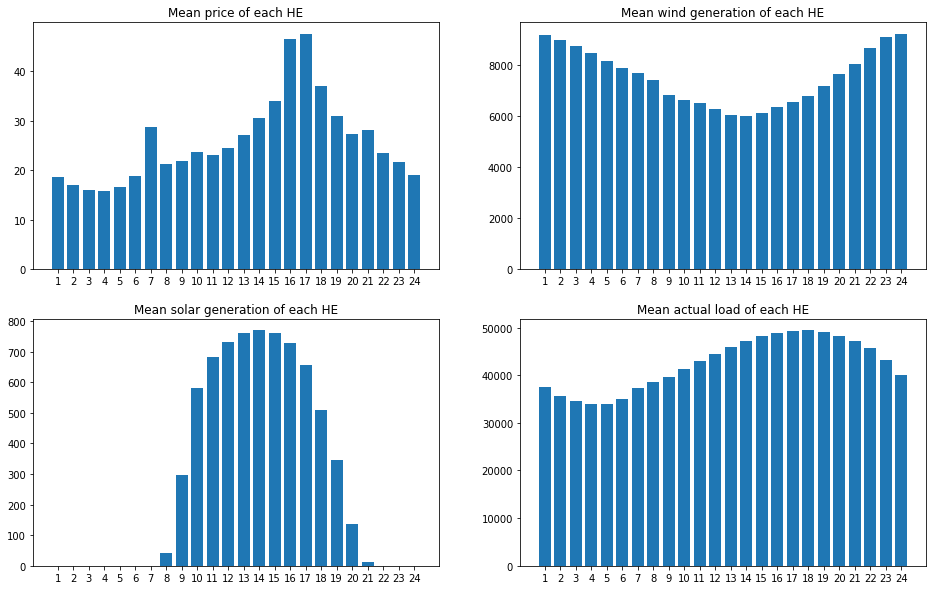

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
axs[0,0].bar(dfhe['HOURENDING'], dfhe['PRICE_MEAN'])
axs[0,0].set_title('Mean price of each HE')
axs[0,0].set_xticks(np.arange(1, 25))
axs[0,1].bar(dfhe['HOURENDING'], dfhe['WIND_MEAN'])
axs[0,1].set_title('Mean wind generation of each HE')
axs[0,1].set_xticks(np.arange(1, 25))
axs[1,0].bar(dfhe['HOURENDING'], dfhe['SOLAR_MEAN'])
axs[1,0].set_title('Mean solar generation of each HE')
axs[1,0].set_xticks(np.arange(1, 25))
axs[1,1].bar(dfhe['HOURENDING'], dfhe['LOAD_MEAN'])
axs[1,1].set_title('Mean actual load of each HE')
axs[1,1].set_xticks(np.arange(1, 25))

In [11]:
dfpeak = (df >> group_by(X.PEAKTYPE) 
          >> summarize(PRICE_MEAN = X.RTLMP.mean(), WIND_MEAN = X.WIND_RTI.mean(), 
                    SOLAR_MEAN = X.GENERATION_SOLAR_RT.mean(), LOAD_MEAN = X.RTLOAD.mean()) 
          >> select(X.PEAKTYPE, X.PRICE_MEAN, X.WIND_MEAN, X.SOLAR_MEAN, X.LOAD_MEAN))

Text(0.5, 1.0, 'Mean actual load of each peak type')

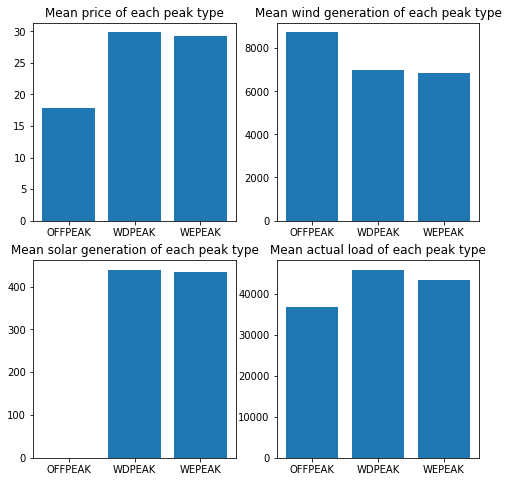

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0,0].bar(dfpeak['PEAKTYPE'], dfpeak['PRICE_MEAN'])
axs[0,0].set_title('Mean price of each peak type')
axs[0,1].bar(dfpeak['PEAKTYPE'], dfpeak['WIND_MEAN'])
axs[0,1].set_title('Mean wind generation of each peak type')
axs[1,0].bar(dfpeak['PEAKTYPE'], dfpeak['SOLAR_MEAN'])
axs[1,0].set_title('Mean solar generation of each peak type')
axs[1,1].bar(dfpeak['PEAKTYPE'], dfpeak['LOAD_MEAN'])
axs[1,1].set_title('Mean actual load of each peak type')

In [13]:
data = './Data/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 10 columns):
DATETIME                       14987 non-null datetime64[ns]
HB_NORTH (RTLMP)               14987 non-null float64
ERCOT (WIND_RTI)               14982 non-null float64
ERCOT (GENERATION_SOLAR_RT)    14983 non-null float64
ERCOT (RTLOAD)                 14987 non-null float64
HOURENDING                     14987 non-null int64
MARKETDAY                      14987 non-null datetime64[ns]
PEAKTYPE                       14987 non-null object
MONTH                          14987 non-null object
YEAR                           14987 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 1.1+ MB


In [14]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14981 entries, 0 to 14984
Data columns (total 10 columns):
DATETIME                       14981 non-null datetime64[ns]
HB_NORTH (RTLMP)               14981 non-null float64
ERCOT (WIND_RTI)               14981 non-null float64
ERCOT (GENERATION_SOLAR_RT)    14981 non-null float64
ERCOT (RTLOAD)                 14981 non-null float64
HOURENDING                     14981 non-null int64
MARKETDAY                      14981 non-null datetime64[ns]
PEAKTYPE                       14981 non-null object
MONTH                          14981 non-null object
YEAR                           14981 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 1.3+ MB


In [15]:
X = df[['ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']]
y = df['HB_NORTH (RTLMP)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1234)

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Randomly guessing mean of training set
y_pred = [np.mean(y_train)]*len(y_test)
print(mse(y_test, y_pred))
print(r2_score(y_test, y_pred))

1097.0294975824393
-0.0001475230363054969


In [18]:
# Simple linear regression and significance of coefficients
X_train1 = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train1).fit(disp = 0)
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:       HB_NORTH (RTLMP)   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     286.3
Date:                Tue, 17 Nov 2020   Prob (F-statistic):          1.63e-179
Time:                        12:23:07   Log-Likelihood:                -63260.
No. Observations:               11984   AIC:                         1.265e+05
Df Residuals:                   11980   BIC:                         1.266e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8488      0.434     59.619      0.0

In [19]:
# OLS
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mse(y_test, y_pred))
print(r2_score(y_test, y_pred))

987.5960578556923
0.0996215204773343


In [20]:
# Ridge with 10-fold CV
a = np.logspace(-2, 3, 50)
reg = RidgeCV(alphas = a, cv = 10).fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mse(y_test, y_pred))
print(r2_score(y_test, y_pred))
print(reg.alpha_)

985.5656236679961
0.10147264091483199
1000.0


In [21]:
# Lasso with 10-fold CV
a = np.logspace(-2, 3, 50)
reg = LassoCV(alphas = a, cv = 10).fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mse(y_test, y_pred))
print(r2_score(y_test, y_pred))
print(reg.alpha_)

987.5546216892553
0.09965929729128276
0.01


In [22]:
# Adding quadratic terms
X_train1 = np.hstack((X_train, np.square(X_train)))
X_test1 = np.hstack((X_test, np.square(X_test)))

In [23]:
# Significance of coefficients with quadratic terms
X_train2 = sm.add_constant(X_train1)
lr = sm.OLS(y_train, X_train2).fit(disp = 0)
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:       HB_NORTH (RTLMP)   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     189.8
Date:                Tue, 17 Nov 2020   Prob (F-statistic):          7.10e-232
Time:                        12:23:09   Log-Likelihood:                -63131.
No. Observations:               11984   AIC:                         1.263e+05
Df Residuals:                   11977   BIC:                         1.263e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7516      0.902     16.360      0.0

In [24]:
# OLS
reg = LinearRegression().fit(X_train1, y_train)
y_pred = reg.predict(X_test1)
print(mse(y_test, y_pred))
print(r2_score(y_test, y_pred))

974.8426066697377
0.11124867602958355


In [25]:
# Ridge
a = np.logspace(-2, 3, 50)
reg = RidgeCV(alphas = a, cv = 10).fit(X_train1, y_train)
y_pred = reg.predict(X_test1)
print(mse(y_test, y_pred))
print(r2_score(y_test, y_pred))
print(reg.alpha_)

972.0353278084764
0.1138080356509521
1000.0


In [26]:
# Lasso
a = np.logspace(-2, 3, 50)
reg = LassoCV(alphas = a, cv = 10).fit(X_train1, y_train)
y_pred = reg.predict(X_test1)
print(mse(y_test, y_pred))
print(r2_score(y_test, y_pred))
print(reg.alpha_)

974.7148005425481
0.11136519521326937
0.01


In [27]:
df = pd.read_excel(data, parse_dates= True)

In [28]:
# Imputation of NAs
index = df['ERCOT (WIND_RTI)'].index[df['ERCOT (WIND_RTI)'].apply(np.isnan)]
for i in index:
    df['ERCOT (WIND_RTI)'][i] = (df['ERCOT (WIND_RTI)'][i-24] + df['ERCOT (WIND_RTI)'][i-48] 
                                 + df['ERCOT (WIND_RTI)'][i-72] + df['ERCOT (WIND_RTI)'][i-96]) / 4
index = df['ERCOT (GENERATION_SOLAR_RT)'].index[df['ERCOT (GENERATION_SOLAR_RT)'].apply(np.isnan)]
for i in index:
    df['ERCOT (GENERATION_SOLAR_RT)'][i] = (df['ERCOT (GENERATION_SOLAR_RT)'][i-24] 
                                            + df['ERCOT (GENERATION_SOLAR_RT)'][i-48] 
                                            + df['ERCOT (GENERATION_SOLAR_RT)'][i-72] 
                                            + df['ERCOT (GENERATION_SOLAR_RT)'][i-96]) / 4

In [29]:
# Encoding
peak_enc = {'OFFPEAK': 0, 'WDPEAK': 1, 'WEPEAK': 2}
df['PEAKTYPE_ENC'] = df['PEAKTYPE'].apply(lambda x: peak_enc[x])
df['MONTH'] = df['MONTH'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)
df = df.drop(['PEAKTYPE', 'MARKETDAY'], axis = 1)

In [30]:
# Train test split
cutoff = pd.to_datetime('2018/5/16')
train = df[df['DATETIME'] <= cutoff]
test = df[df['DATETIME'] > cutoff]

In [31]:
# Shifting data for time series
temp = train.iloc[:-1, 1:5] 
train = train.iloc[1:, :].reset_index(drop = True)
train[['RTLMP-1', 'WIND_RTI-1', 'GENERATION_SOLAR_RT-1', 'RTLOAD-1']] = temp
train = train.drop(['ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)', 'DATETIME'], axis = 1)

In [32]:
# Shifting data for time series
temp = test.iloc[:-1, 1:5].reset_index(drop = True) 
test = test.iloc[1:, :].reset_index(drop = True)
test[['RTLMP-1', 'WIND_RTI-1', 'GENERATION_SOLAR_RT-1', 'RTLOAD-1']] = temp
test = test.drop(['ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)', 'DATETIME'], axis = 1)

In [33]:
# Normalization
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [34]:
# Splitting explanatory and independent variables
y_train = train[:, 0].reshape(-1, 1)
X_train = train[:, 1:]
y_test = test[:, 0].reshape(-1, 1)
X_test = test[:, 1:]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [35]:
# Building LSTM
model = Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.LSTM(50))
model.add(layers.Dense(20))
model.add(layers.Dense(10))
model.add(layers.Dense(1, activation = 'linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            43600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 75,041
Trainable params: 75,041
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Model fitting
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_split=0.1, verbose=0, shuffle=False)

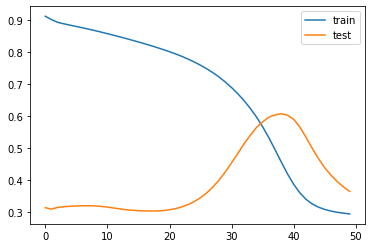

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [38]:
# Evaluation on test set
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((yhat, X_test), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
y_pred = inv_yhat[:,0]
inv_y = np.concatenate((y_test, X_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
y_true = inv_y[:,0]
print(mse(y_true, y_pred))
print(r2_score(y_true, y_pred))

4456.730276082775
0.23750557580832032


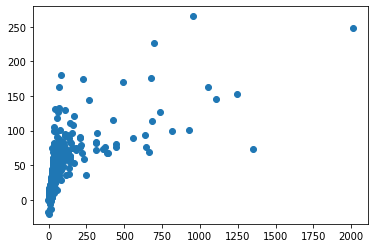

In [39]:
plt.scatter(y_true, y_pred)

Proportion of data kept: 0.9903


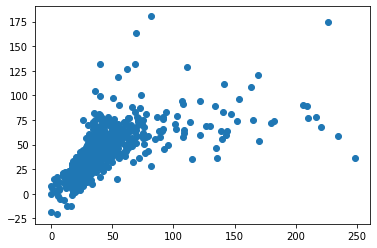

In [40]:
# Removing outlier
y_true_new = []
y_pred_new = []
for i in range(len(y_true)):
    if y_true[i] < 250:
        y_true_new.append(y_true[i])
        y_pred_new.append(y_pred[i])
print("Proportion of data kept: " + str(round(len(y_true_new) / len(y_true), 4)))
plt.scatter(y_true_new, y_pred_new)

In [41]:
# Evalution with outliers removed
print(mse(y_true_new, y_pred_new))
print(r2_score(y_true_new, y_pred_new))

190.83948234147223
0.4701310248732453


In [42]:
# With real-time wind, solar and actual load information
cutoff = pd.to_datetime('2018/5/16')
train1 = df[df['DATETIME'] <= cutoff]
test1 = df[df['DATETIME'] > cutoff]

temp = train1.iloc[:-1, 1:5] 
train1 = train1.iloc[1:, :].reset_index(drop = True)
train1[['RTLMP-1', 'WIND_RTI-1', 'GENERATION_SOLAR_RT-1', 'RTLOAD-1']] = temp
train1 = train1.drop(['DATETIME'], axis = 1)

temp = test1.iloc[:-1, 1:5].reset_index(drop = True) 
test1 = test1.iloc[1:, :].reset_index(drop = True)
test1[['RTLMP-1', 'WIND_RTI-1', 'GENERATION_SOLAR_RT-1', 'RTLOAD-1']] = temp
test1 = test1.drop(['DATETIME'], axis = 1)

scaler = StandardScaler()
train1 = scaler.fit_transform(train1)
test1 = scaler.transform(test1)

y_train1 = train1[:, 0].reshape(-1, 1)
X_train1 = train1[:, 1:]
y_test1 = test1[:, 0].reshape(-1, 1)
X_test1 = test1[:, 1:]
X_train1 = X_train1.reshape((X_train1.shape[0], 1, X_train1.shape[1]))
X_test1 = X_test1.reshape((X_test1.shape[0], 1, X_test1.shape[1]))

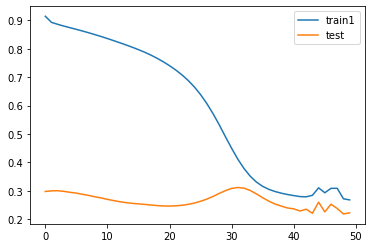

In [43]:
# Cont'd
model1 = Sequential()
model1.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train1.shape[1], X_train1.shape[2])))
model1.add(layers.LSTM(50))
model1.add(layers.Dense(20))
model1.add(layers.Dense(10))
model1.add(layers.Dense(1, activation = 'linear'))
model1.compile(loss='mse', optimizer='adam')
history = model1.fit(X_train1, y_train1, epochs=50, batch_size=72, validation_split=0.1, verbose=0, shuffle=False)
plt.plot(history.history['loss'], label='train1')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [44]:
# New MSE and R^2
yhat = model1.predict(X_test1)
X_test1 = X_test1.reshape((X_test1.shape[0], X_test1.shape[2]))
inv_yhat = np.concatenate((yhat, X_test1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
y_pred1 = inv_yhat[:,0]
inv_y = np.concatenate((y_test1, X_test1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
y_true1 = inv_y[:,0]
print(mse(y_true1, y_pred1))
print(r2_score(y_true1, y_pred1))

4455.572737411522
0.2377036171363659


In [45]:
# New MSE and R^2 without outliers
y_true1_new = []
y_pred1_new = []
for i in range(len(y_true1)):
    if y_true1[i] < 250:
        y_true1_new.append(y_true1[i])
        y_pred1_new.append(y_pred1[i])
print("Proportion of data kept: " + str(round(len(y_true1_new) / len(y_true1), 4)))
print(mse(y_true1_new, y_pred1_new))
print(r2_score(y_true1_new, y_pred1_new))

Proportion of data kept: 0.9903
234.12800351484157
0.34993973076857965
